Goal: Usind data about strokes, build a predictor of which conditions are most likely to result in a sroke.

In [1]:
import pandas as pd
from pandas import DataFrame as df
from config import CONFIG

In [2]:
# EDA
data_loca= CONFIG["DATA_FILEPATH"]
child_bmi_data = CONFIG["CHILD_BMI"]
data = pd.read_csv(data_loca)
child_bmi_df = pd.read_csv(child_bmi_data)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
len(data)

5110

In [6]:
data_df = data.dropna()
len(data_df)

4909

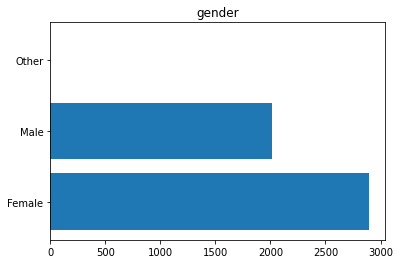

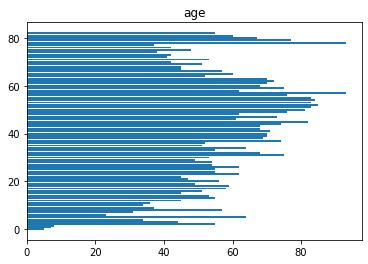

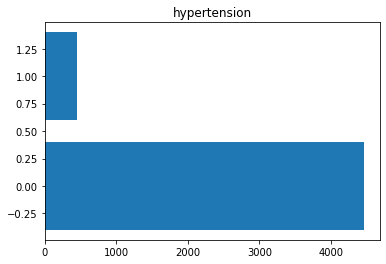

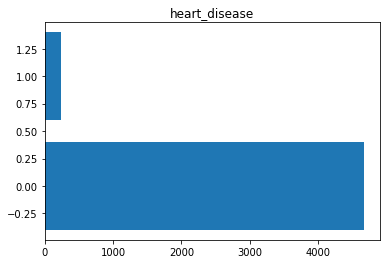

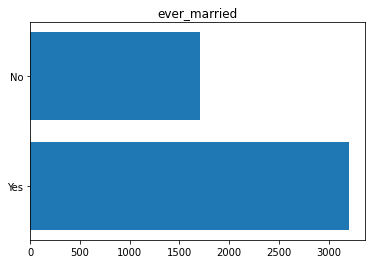

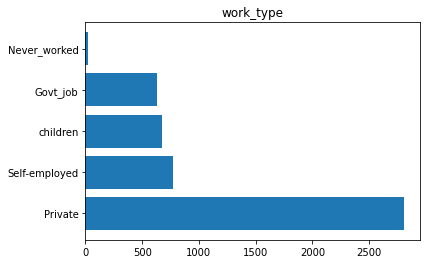

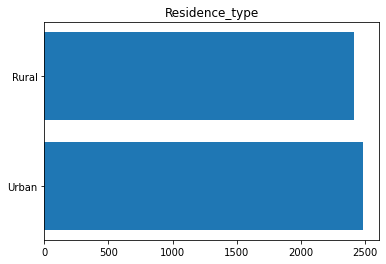

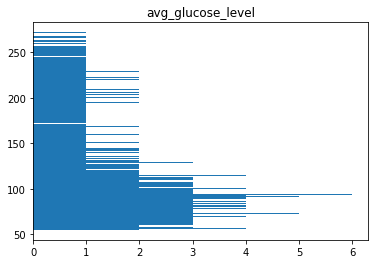

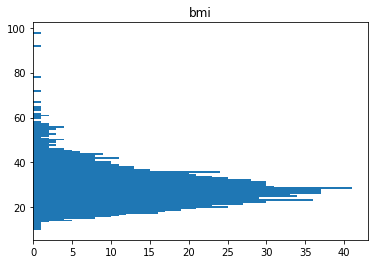

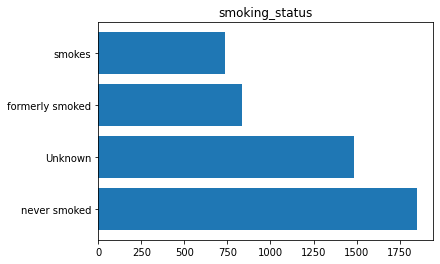

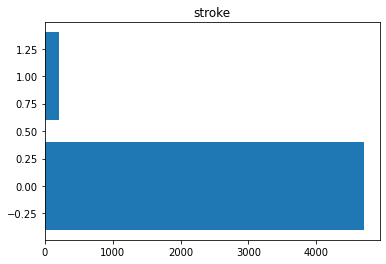

In [8]:
# get histograms of all data to see spread
import matplotlib.pyplot as plt
cols = ["gender", "age", "hypertension", "heart_disease","ever_married", "work_type","Residence_type", "avg_glucose_level","bmi","smoking_status","stroke"]
for col in cols:
    # counts = data_df[col].value_counts().plot.barh()
    # fig, ax = plt.subplots()
    # ax.set_title(f"{col}")
    # plt.show()

    categories = data_df[col].value_counts().index
    counts = data_df[col].value_counts().values
    plt.barh(categories, counts)
    plt.title(col)
    plt.show()


These files contain the L, M, and S parameters needed to generate exact percentiles and z-scores along with the percentile values for the 3rd, 5th, 10th, 25th, 50th, 75th, 90th, 95th, and 97th percentiles by sex (1=male; 2=female) and single month of age. The smoothed 85th percentile values are included in the BMI-for-age and weight-for-stature tables. Age is listed at the half month point for the entire month; for example, 1.5 months represents 1.0-1.99 months or 1.0 month up to but not including 2.0 months of age. The only exception is birth, which represents the point at birth. To obtain L, M, and S values at finer age or length/stature intervals interpolation could be used.

The LMS parameters are the median (M), the generalized coefficient of variation (S), and the power in the Box-Cox transformation (L). To obtain the value (X) of a given physical measurement at a particular z-score or percentile, use the following equation:

X = M (1 + LSZ)**(1/L), L ≠ 0

Or

X = M exp(SZ), L = 0

where the L, M, and S are the values from the appropriate table corresponding to the age in months of the child (** indicates an exponent, such that M(1+LSZ)**(1/L) means raising (1+LSZ) to the (1/L)th power and then multiplying the M; exp(X) is the exponentiation function, e to the power X). Z is the z-score that corresponds to the percentile. z-scores correspond exactly to percentiles, e.g., z-scores of -1.881, -1.645, -1.282, -0.674, 0, 0.674, 1.036, 1.282, 1.645, and 1.881 correspond to the 3rd, 5th, 10th, 25th, 50th, 75th, 85th, 90th, 95th, and 97th percentiles, respectively.

For example, to obtain the 5th percentile of weight-for-age for a 9-month-old male, we would look up the L, M and S values from the WTAGEINF table, which are L=-0.1600954, M=9.476500305, and S=0.11218624. For the 5th percentile, we would use Z=-1.645. Using the equation above, we calculate that the 5th percentile is 7.90 kg.

To obtain the z-score (Z) and corresponding percentile for a given measurement (X), use the following equation:

((X/M)**L) – 1
Z = ————————-, L≠0
LS

or

Z = ln(X/M)/S ,L=0

where X is the physical measurement (e.g. weight, length, head circumference, stature or calculated BMI value) and L, M and S are the values from the appropriate table corresponding to the age in months of the child (or length/stature). (X/M)**L means raising the quantity (X/M) to the Lth power.

For example, to obtain the weight-for-age z-score of a 9-month-old male who weighs 9.7 kg, we would look up the L, M and S values from the WTAGEINF table, which are L=-0.1600954, M=9.476500305, and S=0.11218624. Using the equation above, we calculate that the z-score for this child is 0.207. This z-score corresponds to the 58th percentile.

Z-scores and corresponding percentiles can be obtained from standard normal distribution tables found in statistics text books. Standard normal tables can also be found on the internet by doing a search on a “standard normal table.” In addition, many computer programs have pre-existing functions that convert Z-scores to percentiles and vice versa.



In [3]:
child_bmi_df.head()

,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P85,P90,P95,P97
0,1,24,-2.01118107,16.57502768,0.080592465,14.52095333,14.73731947,15.09032827,15.74164233,16.57502768,17.55718781,18.16219473,18.60948128,19.33801062,19.85985812
1,1,24.5,-1.982373595,16.54777487,0.080127429,14.50347667,14.71929257,15.07117474,15.71962876,16.54777487,17.52129279,18.11954923,18.56110634,19.27889813,19.79194014
2,1,25.5,-1.924100169,16.49442763,0.079233994,14.46882381,14.68360841,15.03335725,15.67634464,16.49442763,17.45135039,18.03668013,18.46729593,19.16465965,19.66102345
3,1,26.5,-1.86549793,16.44259552,0.078389356,14.43459737,14.64843329,14.99619505,15.634035,16.44259552,17.38383656,17.95700228,18.37736191,19.05567423,19.5365754
4,1,27.5,-1.807261899,16.3922434,0.077593501,14.40082828,14.61378626,14.95969047,15.5926798,16.3922434,17.3187102,17.88047101,18.29125345,18.9518675,19.41848805


In [22]:
sex_mask = child_bmi_df["Sex"] == 1
age_mask = child_bmi_df["Agemos"] == 24
# child_bmi_df[sex_mask & age_mask]
child_bmi_df[sex_mask]

,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P85,P90,P95,P97


In [ ]:
import math
def calc_bmi_percentile(gender,age,bmi, bmi_table):
    """
    This is a function that calculates the percentile of a child's BMI and returns their weight category.
    """
    code_gender = 1 if gender == "Male" else 2
    code_age = age * 12

    specific_row = bmi_table["Sex"]
    L = bmi_table["L"].where(bmi_table["Sex"]==)
    M = bmi_table["M"]
    S = bmi_table["S"]

    Z = ((bmi/M)**L)-1 / (L*S) if L != 0 else math.log(X/M)/L
    percentile = mean + Z*std


    c_under = percentile < 5
    c_healthy = 5 <= percentile < 85
    c_over = 85 <= percentile < 95
    c_obese = percentile >= 95

    
    
    return weight_category

In [ ]:
#data transformations:

# bucket age 10 year buckets



# bucket bmi 
# under weight, healthy weight, over weight, obese (for adults)
adult_weight = 0 # placeholder. I want weight when age is > 20
under = (0,18.5)
healthy = (18.5,24.9)
over = (25.0,29.9)
obese = (30.0,100)
#  for kids its based on percentile
c_percentile = 0 # placeholder. I want weight when age is <= 20
# percentile also needs to reflect age group and gender
c_under = c_percentile < 5
c_healthy = 5 <= c_percentile < 85
c_over = 85 <= c_percentile < 95
c_obese = c_percentile >= 95